Click [here](https://gitlab.com/api/v4/projects/56283350/jobs/artifacts/main/raw/notebooks/quantics2d.ipynb?job=pages) to download the notebook locally.


# Quantics TCI of multivariate funciton


In [1]:
import TensorCrossInterpolation as TCI
import QuanticsGrids: DiscretizedGrid, origcoord_to_quantics, origcoord_to_grididx
using QuanticsTCI
using PythonPlot: pyplot as plt
using PythonPlot: Figure
using PythonCall: Py
_display(fig::Figure) = isinteractive() ? (fig; plt.show(); nothing) : Base.display(fig)
_display(fig::Py) = _display(Figure(fig))
# pythonplot() # use pythonplot backend for plotting
using LaTeXStrings

## Artificial function with widely different length scales


In [2]:
f(x, y) = (exp(-0.4 * (x^2 + y^2)) + 1 + sin(x * y) * exp(-x^2) +
           cos(3 * x * y) * exp(-y^2) + cos(x + y)) + 0.05 * cos(1 / 0.001 * (0.2 * x - 0.4 * y)) + 0.0005 * cos(1 / 0.0001 * (-0.2 * x + 0.7 * y)) + 1e-5 * cos(1 / 1e-7 * (20 * x))

R = 40
gr = DiscretizedGrid{2}(R, (-5, -5), (5, 5))

DiscretizedGrid{2}(40, (-5.0, -5.0), (5.0, 5.0), 2, :fused, false)

In [3]:
function myplotheatmap(ax, func, xlim::Tuple, ylim::Tuple; xlim_box=nothing, ylim_box=nothing, cmap="inferno")
    x = LinRange(xlim..., 400)
    y = LinRange(ylim..., 400)
    s = ax.pcolormesh(x, y, func.(x, y'), cmap=cmap)
    if !isnothing(xlim_box) && !isnothing(ylim_box)
        ax.plot(
            [xlim_box[1], xlim_box[2], xlim_box[2], xlim_box[1], xlim_box[1]],
            [ylim_box[1], ylim_box[1], ylim_box[2], ylim_box[2], ylim_box[1]],
            color="lightgreen", lw=2, label="",
        )
    end
    plt.colorbar(s, ax=ax, orientation="vertical", pad=0.11)
    ax.set_xlabel(raw"$x$")
    ax.set_ylabel(raw"$y$")
    ax
end

function myplotheatmap(func, xlim::Tuple, ylim::Tuple; xlim_box=nothing, ylim_box=nothing, cmap="inferno")
    fig, ax = plt.subplots()
    myplotheatmap(ax, func, xlim, ylim; xlim_box, ylim_box, cmap)
    _display(fig)
end

myplotheatmap (generic function with 2 methods)

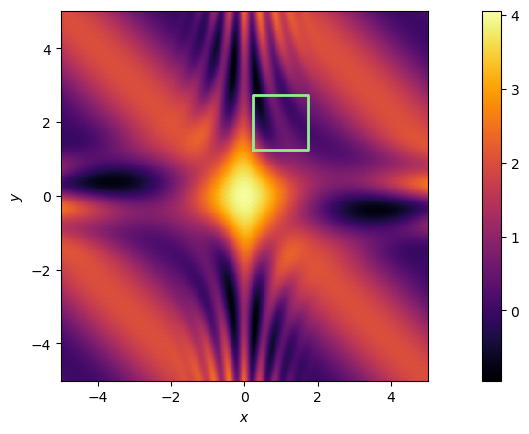

In [4]:
myplotheatmap(f, (-5, 5), (-5, 5), xlim_box=(0.25, 1.75), ylim_box=(1.25, 2.75), cmap="inferno")

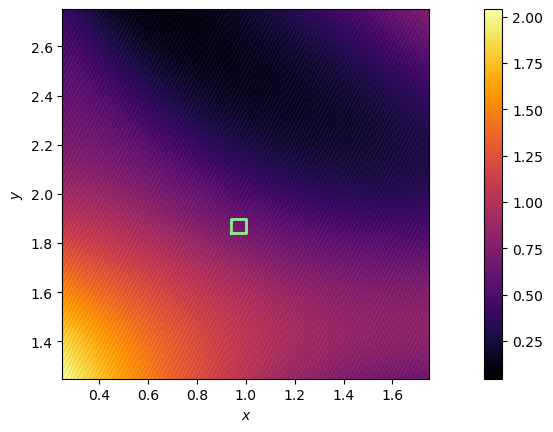

In [5]:
myplotheatmap(f, (0.25, 1.75), (1.25, 2.75), xlim_box=(0.94, 1.0), ylim_box=(1.84, 1.9))

In [6]:
myplotheatmap(f, (0.94, 1.0), (1.84, 1.9), xlim_box=(0.97, 0.97 + 1e-7), ylim_box=(1.88, 1.88 + 1e-7))

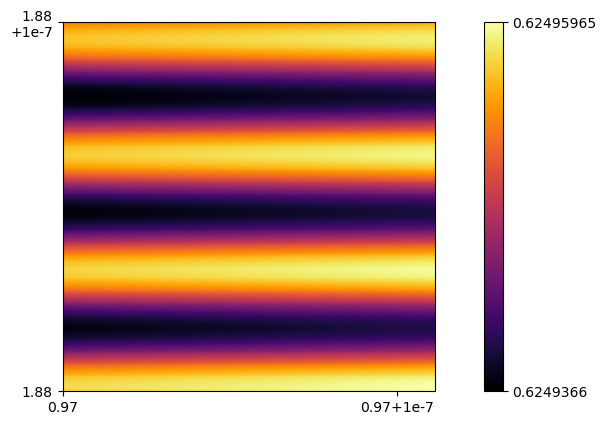

In [7]:
fig, ax = plt.subplots()
xs = LinRange(0.97, 0.97 + 1e-7, 400)
ys = LinRange(1.88, 1.88 + 1e-7, 400)
s = ax.pcolormesh(xs, ys, f.(xs, ys'), cmap="inferno")
cbar = fig.colorbar(s, ax=ax, orientation="vertical", pad=0.1)
cbar.ax.set_yticks([0.6249366, 0.62495965])
cbar.ax.set_yticklabels(["0.6249366", "0.62495965"])

ax.set_xticks([0.97, 0.97 + 0.9e-7])
ax.set_xticklabels([0.97, "0.97+1e-7"])
ax.set_yticks([1.88, 1.88 + 1e-7])
ax.set_yticklabels([1.88, "1.88" * "\n" * "+1e-7"])

_display(fig)

In [8]:
# Construct 2D quantics
fig, ax = plt.subplots()
qtci, ranks, errors = quanticscrossinterpolate(Float64, f, gr)
ax.plot(qtci.tci.pivoterrors ./ qtci.tci.maxsamplevalue)
ax.set_xlabel(L"\chi")
ax.set_ylabel("Normalized error")
ax.set_yscale("log")
_display(fig)

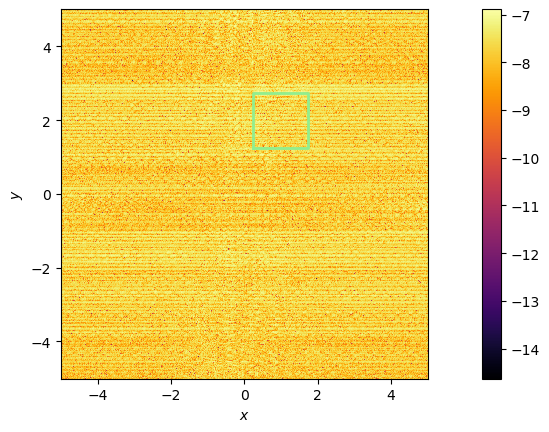

In [9]:
# Function that evaluates log10 of the interplation error at (x, y)
errflog10(x, y) = log10(abs(f(x, y) - qtci(origcoord_to_grididx(gr, (x, y)))))

eps = 1e-10
myplotheatmap(errflog10, (-5, 5 - eps), (-5, 5 - eps), xlim_box=(0.25, 1.75), ylim_box=(1.25, 2.75))

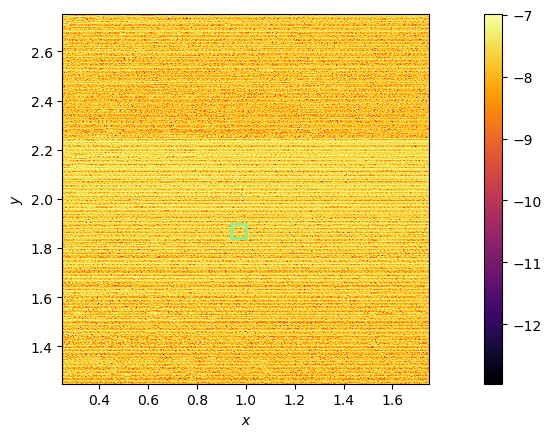

In [10]:
myplotheatmap(errflog10, (0.25, 1.75), (1.25, 2.75), xlim_box=(0.94, 1.0), ylim_box=(1.84, 1.9))

In [11]:
myplotheatmap(errflog10, (0.94, 1.0), (1.84, 1.9), xlim_box=(0.97, 0.97 + 1e-7), ylim_box=(1.88, 1.88 + 1e-7))

In [12]:
fig, ax = plt.subplots()
xs = LinRange(0.97, 0.97 + 1e-7, 400)
ys = LinRange(1.88, 1.88 + 1e-7, 400)
s = ax.pcolormesh(xs, ys, errflog10.(xs, ys'), cmap="inferno")
fig.colorbar(s, ax=ax, orientation="vertical", pad=0.11)
ax.set_xticks([0.97, 0.97 + 0.9e-7])
ax.set_xticklabels([0.97, "0.97+1e-7"])
ax.set_yticks([1.88, 1.88 + 1e-7])
ax.set_yticklabels([1.88, "1.88" * "\n" * "+1e-7"])

_display(fig)

## Low-rank structure in Fourier transform matrix


In [13]:
import TensorCrossInterpolation as TCI
import QuanticsGrids as QD

R = 20 # R must be even

# 1D grid with 2^R points starting at 0
grid = QD.InherentDiscreteGrid{1}(R, 0)

# Fourier transform matrix
fkm(k::Int, m::Int) = exp(-2ฯ * im * k * m / 2^R) / 2^(R รท 2)

function fq(fused_quantics_index::Vector{Int})
    # Compute quantics indices for k and m
    kq, mq = QD.unfuse_dimensions(fused_quantics_index, 2)
    reverse!(kq) # bit reversal
    return fkm(
        QD.quantics_to_origcoord(grid, kq),
        QD.quantics_to_origcoord(grid, mq)
    )
end

localdims = fill(2^2, R)
firstpivots = [ones(Int, R)]
qtci, ranks, errors = TCI.crossinterpolate2(ComplexF64, fq, localdims, firstpivots; tolerance=1e-8, verbosity=1, loginterval=1)

fig, ax = plt.subplots()
ax.plot(qtci.pivoterrors, label="pivot errors")
ax.set_yscale("log")
ax.legend()
_display(fig)

iteration = 1, rank = 10, error= 1.690286197068603e-12, maxsamplevalue= 0.0009765625, nglobalpivot=5
  Rejected 5 global pivots added in the previous iteration, errors are [4.757835607586789e-13, 1.0341194629397989e-12, 7.0412512245535244e-12, 3.5978379387870684e-12, 1.1666802215401787e-12]
iteration = 2, rank = 10, error= 8.66919414722159e-12, maxsamplevalue= 0.0009765625, nglobalpivot=0
iteration = 3, rank = 10, error= 5.430620374765639e-12, maxsamplevalue= 0.0009765625, nglobalpivot=0
iteration = 4, rank = 10, error= 5.430620374765639e-12, maxsamplevalue= 0.0009765625, nglobalpivot=0


  Rejected 5 global pivots added in the previous iteration, errors are [4.757835607586789e-13, 1.0341194629397989e-12, 7.0412512245535244e-12, 3.5978379387870684e-12, 1.1666802215401787e-12]


iteration = 2, rank = 10, error= 8.66919414722159e-12, maxsamplevalue= 0.0009765625, nglobalpivot=0


iteration = 3, rank = 10, error= 5.430620374765639e-12, maxsamplevalue= 0.0009765625, nglobalpivot=0


iteration = 4, rank = 10, error= 5.430620374765639e-12, maxsamplevalue= 0.0009765625, nglobalpivot=0
